In [1]:
import cv2
import numpy as np
import scipy.signal as signal
import scipy.fftpack as fftpack

In [2]:
#convert RBG to YIQ
def rgb2ntsc(src):
    [rows,cols]=src.shape[:2]
    dst=np.zeros((rows,cols,3),dtype=np.float64)
    T = np.array([[0.114, 0.587, 0.298], [-0.321, -0.275, 0.596], [0.311, -0.528, 0.212]])
    for i in range(rows):
        for j in range(cols):
            dst[i, j]=np.dot(T,src[i,j])
    return dst

In [3]:
def ntsc2rbg(src):
    [rows, cols] = src.shape[:2]
    dst=np.zeros((rows,cols,3),dtype=np.float64)
    T = np.array([[1, -1.108, 1.705], [1, -0.272, -0.647], [1, 0.956, 0.620]])
    for i in range(rows):
        for j in range(cols):
            dst[i, j]=np.dot(T,src[i,j])
    return dst

In [4]:
#Build Gaussian Pyramid
def build_gaussian_pyramid(src,level=3):
    s=src.copy()
    pyramid=[s]
    for i in range(level):
        s=cv2.pyrDown(s)
        pyramid.append(s)
    return pyramid

In [5]:
#Build Laplacian Pyramid
def build_laplacian_pyramid(src,levels=3):
    gaussianPyramid = build_gaussian_pyramid(src, levels)
    pyramid=[]
    for i in range(levels,0,-1):
        GE=cv2.pyrUp(gaussianPyramid[i])
        L=cv2.subtract(gaussianPyramid[i-1],GE)
        pyramid.append(L)
    return pyramid

In [6]:
def load_video(video_filename):
    cap=cv2.VideoCapture(video_filename)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width, height = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    video_tensor=np.zeros((frame_count,height,width,3),dtype='float')
    x=0
    while cap.isOpened():
        ret,frame=cap.read()
        if ret is True:
            video_tensor[x]=frame
            x+=1
        else:
            break
    return video_tensor,fps

In [7]:
# apply temporal ideal bandpass filter to gaussian video
def temporal_ideal_filter(tensor,low,high,fps,axis=0):
    fft=fftpack.fft(tensor,axis=axis)
    frequencies = fftpack.fftfreq(tensor.shape[0], d=1.0 / fps)
    bound_low = (np.abs(frequencies - low)).argmin()
    bound_high = (np.abs(frequencies - high)).argmin()
    fft[:bound_low] = 0
    fft[bound_high:-bound_high] = 0
    fft[-bound_low:] = 0
    iff=fftpack.ifft(fft, axis=axis)
    return np.abs(iff)

In [8]:
# build gaussian pyramid for video
def gaussian_video(video_tensor,levels=3):
    for i in range(0,video_tensor.shape[0]):
        frame=video_tensor[i]
        pyr=build_gaussian_pyramid(frame,level=levels)
        gaussian_frame=pyr[-1]
        if i==0:
            vid_data=np.zeros((video_tensor.shape[0],gaussian_frame.shape[0],gaussian_frame.shape[1],3))
        vid_data[i]=gaussian_frame
    return vid_data

In [9]:
#amplify the video
def amplify_video(gaussian_vid,amplification=50):
    return gaussian_vid*amplification

In [10]:
def reconstract_video(amp_video,origin_video,levels=3):
    final_video=np.zeros(origin_video.shape)
    for i in range(0,amp_video.shape[0]):
        img = amp_video[i]
        
        for x in range(levels):
            img=cv2.pyrUp(img)
        print(img.shape,origin_video[i].shape)
        img=img+origin_video[i]
        final_video[i]=img
    return final_video

In [11]:
def magnify_color(video_name,low,high,levels=3,amplification=50):
    t,f=load_video(video_name)
    print(f)
    gau_video=gaussian_video(t,levels=levels)
    filtered_tensor=temporal_ideal_filter(gau_video,low,high,f)
    amplified_video=amplify_video(filtered_tensor,amplification=amplification)
    final=reconstract_video(amplified_video,t,levels=3)
    print(final)
    return final

In [15]:
final=magnify_color('youness.mp4',1,1.5)

30


KeyboardInterrupt: 

In [16]:
for i in range(0,final.shape[0]):
    cv2.imshow('frame',final[i]/255)
    k=cv2.waitKey(10)
    if k ==ord("q"):
        break
cv2.destroyAllWindows()

NameError: name 'final' is not defined

In [17]:
cv2.destroyAllWindows()

In [18]:
# def load_video(video_filename):
#     cap=cv2.VideoCapture(0)
#     # frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#     # width, height = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
#     fps = int(cap.get(cv2.CAP_PROP_FPS))
#     video_tensor=[]
#     x=0
#     while cap.isOpened():
#         ret,frame=cap.read()
        
#         cv2.imshow('frame',frame)
#         video_tensor.append(frame)
#         x+=1
        
#     video_tensor=np.array(video_tensor)
#     return video_tensor,fps
# load_video('youness.mp4')

In [12]:
cap = cv2.VideoCapture(0)
vid_data=[]
while cap.isOpened():
    ret,frame=cap.read()
    if ret is True:
        cv2.imshow('frame',frame)
        vid_data.append(frame)
        k=cv2.waitKey(10)
        if k ==ord("q"):
            break
    else:
        break
cap.release()
cv2.destroyAllWindows()
print(np.array(vid_data))

[[[[ 54  53  39]
   [ 57  51  45]
   [ 63  51  54]
   ...
   [255 255 255]
   [253 253 253]
   [253 253 253]]

  [[ 54  51  45]
   [ 60  51  49]
   [ 64  49  53]
   ...
   [255 255 255]
   [253 253 253]
   [253 253 253]]

  [[ 52  49  54]
   [ 59  49  55]
   [ 64  49  55]
   ...
   [254 254 254]
   [253 253 253]
   [253 253 253]]

  ...

  [[ 29  24  26]
   [ 30  24  25]
   [ 30  23  23]
   ...
   [ 62  46  42]
   [ 60  45  42]
   [ 60  45  42]]

  [[ 29  24  24]
   [ 31  23  23]
   [ 34  22  23]
   ...
   [ 63  48  42]
   [ 60  46  40]
   [ 59  44  39]]

  [[ 29  24  24]
   [ 29  23  23]
   [ 30  23  23]
   ...
   [ 63  48  42]
   [ 61  47  41]
   [ 60  46  40]]]


 [[[ 57  45  39]
   [ 56  41  46]
   [ 55  37  53]
   ...
   [255 255 255]
   [254 254 254]
   [254 254 254]]

  [[ 49  42  43]
   [ 55  44  48]
   [ 59  44  52]
   ...
   [255 255 255]
   [253 253 253]
   [253 253 253]]

  [[ 52  44  47]
   [ 57  47  52]
   [ 59  47  53]
   ...
   [254 254 254]
   [253 253 253]
   [253 253

In [16]:
import time
import cv2
detector=cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_alt.xml')
cap = cv2.VideoCapture(0)
fps = int(cap.get(cv2.CAP_PROP_FPS))
vid_data=[]
curr_time=time.time()
while cap.isOpened():
    ret,frame=cap.read()
    if time.time()-curr_time>10:
        break
    frame=cv2.flip(frame,1)
    gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    rects = detector.detectMultiScale(gray, scaleFactor=1.05,
        minNeighbors=5, minSize=(30, 30),
        flags=cv2.CASCADE_SCALE_IMAGE)
    for x,y,w,h in rects:
        # cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)
        pass
    if ret is True:
        cv2.imshow('frame',frame)
        vid_data.append(frame)
        k=cv2.waitKey(10)
        if k ==ord("q"):
            break
    else:
        break
cap.release()
cv2.destroyAllWindows()
vid_data=np.array(vid_data)

In [17]:
def reconstract_video(amp_video,origin_video,levels=3):
    final_video=np.zeros(origin_video.shape)
    for i in range(0,amp_video.shape[0]):
        img = amp_video[i]
        
        for x in range(levels):
            img=cv2.pyrUp(img)
        print(img.shape,origin_video[i].shape)
        img=img+origin_video[i]
        final_video[i]=img
    return final_video

In [18]:
def magnify_color(video_name,low,high,levels=3,amplification=50):
    # t,f=load_video(video_name)
    t=vid_data
    f=fps
    print(f)
    gau_video=gaussian_video(t,levels=levels)
    print(t.shape)
    filtered_tensor=temporal_ideal_filter(gau_video,low,high,f)
    amplified_video=amplify_video(filtered_tensor,amplification=amplification)
    final=reconstract_video(amplified_video,t,levels=levels)
    print(final)
    return final

In [20]:
final=magnify_color('youness.mp4',0.8,1,4,50)
print(final,cv2.convertScaleAbs(final[0]))

30
(114, 480, 640, 3)
(480, 640, 3) (480, 640, 3)
(480, 640, 3) (480, 640, 3)
(480, 640, 3) (480, 640, 3)
(480, 640, 3) (480, 640, 3)
(480, 640, 3) (480, 640, 3)
(480, 640, 3) (480, 640, 3)
(480, 640, 3) (480, 640, 3)
(480, 640, 3) (480, 640, 3)
(480, 640, 3) (480, 640, 3)
(480, 640, 3) (480, 640, 3)
(480, 640, 3) (480, 640, 3)
(480, 640, 3) (480, 640, 3)
(480, 640, 3) (480, 640, 3)
(480, 640, 3) (480, 640, 3)
(480, 640, 3) (480, 640, 3)
(480, 640, 3) (480, 640, 3)
(480, 640, 3) (480, 640, 3)
(480, 640, 3) (480, 640, 3)
(480, 640, 3) (480, 640, 3)
(480, 640, 3) (480, 640, 3)
(480, 640, 3) (480, 640, 3)
(480, 640, 3) (480, 640, 3)
(480, 640, 3) (480, 640, 3)
(480, 640, 3) (480, 640, 3)
(480, 640, 3) (480, 640, 3)
(480, 640, 3) (480, 640, 3)
(480, 640, 3) (480, 640, 3)
(480, 640, 3) (480, 640, 3)
(480, 640, 3) (480, 640, 3)
(480, 640, 3) (480, 640, 3)
(480, 640, 3) (480, 640, 3)
(480, 640, 3) (480, 640, 3)
(480, 640, 3) (480, 640, 3)
(480, 640, 3) (480, 640, 3)
(480, 640, 3) (480, 640, 3

In [191]:
for i in range(0,final.shape[0]):
    cv2.imshow('frame',cv2.convertScaleAbs(final[i]))
    k=cv2.waitKey(10)
    if k ==ord("q"):
        break
cv2.destroyAllWindows()

In [192]:
cv2.destroyAllWindows()

In [193]:
def save_video(video_tensor):
    fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
    [height,width]=video_tensor[0].shape[0:2]
    writer = cv2.VideoWriter("out.avi", fourcc, 30, (width, height), 1)
    for i in range(0,video_tensor.shape[0]):
        writer.write(cv2.convertScaleAbs(video_tensor[i]))
    writer.release()
save_video(final)
cv2.destroyAllWindows()

In [111]:
gau_video=gaussian_video(vid_data,levels=6)

In [112]:
for i in range(0,gau_video.shape[0]):
    cv2.imshow('frame',gau_video[i]/255)
    k=cv2.waitKey(0)
    if k ==ord("q"):
        break
    if k == ord(' '):
        pass
cv2.destroyAllWindows()

In [109]:
cv2.destroyAllWindows()

In [203]:
# apply temporal ideal bandpass filter to gaussian video
def temporal_ideal_filter(tensor,low,high,fps,axis=0):
    fft=fftpack.fft(tensor,axis=axis)
    frequencies = fftpack.fftfreq(tensor.shape[0], d=1.0 / fps)
    bound_low = (np.abs(frequencies - low)).argmin()
    bound_high = (np.abs(frequencies - high)).argmin()
    fft[:bound_low] = 0
    fft[bound_high:-bound_high] = 0
    fft[-bound_low:] = 0
    for i in range(len(fft)):
        for j in range(len(fft[i])):
            for k in range(len(fft[i,j])):
                print(fft[i,j,k])
    iff=fftpack.ifft(fft, axis=axis)
    # print(iff)
    return np.abs(iff)

c:\Users\Dell Latitude 5420\.conda\envs\Factory_Safety\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Dell Latitude 5420\.conda\envs\Factory_Safety\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


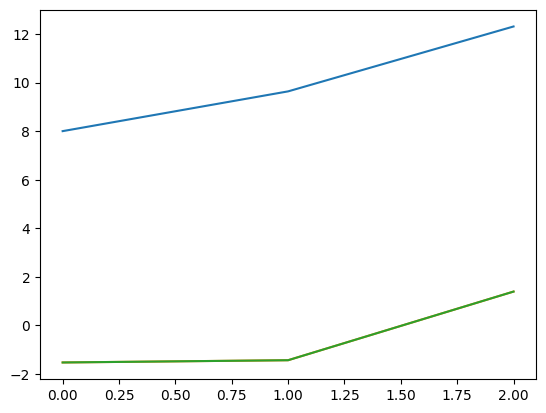